In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay


In [2]:
# clean the data
stat = open ("player_injuries_impact.csv", "r",encoding="utf8")

stat.seek(0)
info = stat.readline().strip()
headers = info.split(",")
#get the headers needed for project
impHeaders = headers[:9] + [headers[12], headers[41]] 
print(impHeaders)


['Name', 'Team Name', 'Position', 'Age', 'Season', 'FIFA rating', 'Injury', 'Date of Injury', 'Date of return', 'Match1_before_injury_Player_rating', 'Match3_after_injury_Player_rating']


In [3]:
#Clean data

players = []

playstats = list(range(9)) + [12, 41]
Headers_need = [headers[i] for i in playstats]
                            
for line in csv.reader(stat):
    selected_values = [line[i] if i < len(line) else "" for i in playstats]
    players.append(", ".join(selected_values))
#get the first 200 players stats for needed info: 657 in total
for player in players[:657]:
    #print(player)

    stat.close()


In [4]:
# do some modelling

In [ ]:
# Clean the data
with open("player_injuries_impact.csv", "r", encoding="utf8") as stat:
    reader = csv.reader(stat)
    headers = next(reader)  # Read the header row
    playstats = list(range(9)) + [12, 41]  # Columns relevant to the model
    data = []

    for row in reader:
        selected_values = [row[i] if i < len(row) else "" for i in playstats]
        data.append(selected_values)

In [ ]:
# Convert data to a NumPy array
data = np.array(data)

In [ ]:
# Feature selection
X = data[:, :-1]  # All columns except the last one
y = data[:, -1]   # Last column (target)

In [ ]:
# Handle missing values
X[X == ""] = -1
y[y == ""] = -1

In [ ]:
# Convert strings to numeric
def to_float_safe(value):
    try:
        return float(value)
    except ValueError:
        return -1  # Replace non-numeric values with -1

X = np.vectorize(to_float_safe)(X)
y = np.vectorize(to_float_safe)(y)

In [ ]:
# Target variable y represnets "performance after injury" based on player rating, match performance, etc..
bins = [0, 3, 6, 10]
labels = [0, 1, 2]  
y = np.digitize(y, bins, right=True) - 1  # Assign class labels

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the model
rf_model.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

In [ ]:
#### Feature Importance ####
feature_importances = rf_model.feature_importances_

# Sorting features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = sorted_indices[:5]  # Get the top 5 features

In [ ]:
# Displaying feature importance as a ranked list
print("Top 5 Features by Importance:")
for rank, idx in enumerate(top_features, start=1):
    print(f"{rank}. Feature: {headers[idx]}, Importance: {feature_importances[idx]:.4f}")

In [ ]:
#### Cross-Validation ####
cv_scores = cross_val_score(rf_model, X, y, cv=5)  # 5-fold cross-validation

In [ ]:
# Cross-Validation results
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

In [ ]:
#### ROC CURVE ####
y_binarized = label_binarize(y, classes=[-1, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

In [ ]:
# Training the classifier (One-vs-Rest strategy for multi-class)
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

In [ ]:
# Predicted probabilities
y_score = clf.predict_proba(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# ROC curve for each class
plt.figure(figsize=(10, 6))
for i, color in zip(range(y_binarized.shape[1]), ['blue', 'red', 'green']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

In [ ]:
# Plots for ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print("AUROC for each class:")
for i in range(y_binarized.shape[1]):
    print(f"Class {i}: {roc_auc[i]:.4f}")

In [11]:
#train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
AB_model = AdaBoostClassifier(n_estimators=100, random_state=42)

In [13]:
AB_model.fit(X_train, y_train)

c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [14]:
y_pred = AB_model.predict(X_test)

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.4696969696969697
Classification Report:
              precision    recall  f1-score   support

          -1       0.45      0.47      0.46        53
           1       0.25      0.10      0.14        21
           2       0.51      0.60      0.56        58

    accuracy                           0.47       132
   macro avg       0.40      0.39      0.38       132
weighted avg       0.45      0.47      0.45       132



In [16]:
#### Feature Importance ####
feature_importances = AB_model.feature_importances_

# Sorting features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = sorted_indices[:5]  # Get the top 5 features

In [17]:
# Displaying feature importance as a ranked list
print("Top 5 Features by Importance:")
for rank, idx in enumerate(top_features, start=1):
    print(f"{rank}. Feature: {headers[idx]}, Importance: {feature_importances[idx]:.4f}")

Top 5 Features by Importance:
1. Feature: FIFA rating, Importance: 0.5600
2. Feature: Age, Importance: 0.3800
3. Feature: Match1_before_injury_Result, Importance: 0.0600
4. Feature: Date of return, Importance: 0.0000
5. Feature: Date of Injury, Importance: 0.0000


In [18]:
#### Cross-Validation ####
cv_scores = cross_val_score(AB_model, X, y, cv=5)  # 5-fold cross-validation

c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

In [19]:
# Cross-Validation results
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")


Cross-Validation Scores: [0.42424242 0.38931298 0.45038168 0.51908397 0.49618321]
Mean CV Accuracy: 0.4558408512606985


In [20]:
#### ROC CURVE ####
y_binarized = label_binarize(y, classes=[-1, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

In [21]:
# Training the classifier (One-vs-Rest strategy for multi-class)
clf = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\sx4400jb\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


OneVsRestClassifier(estimator=AdaBoostClassifier(n_estimators=100,
                                                 random_state=42))

In [22]:
# Predicted probabilities
y_score = clf.predict_proba(X_test)

In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

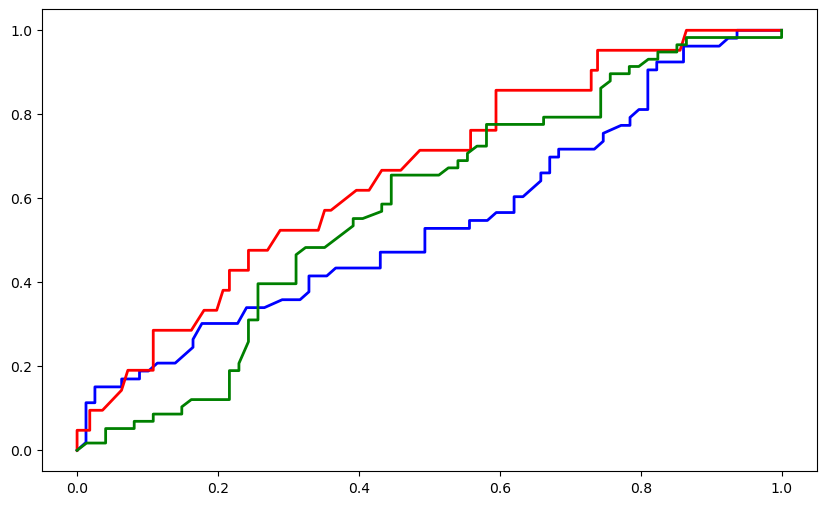

In [24]:
# ROC curve for each class
plt.figure(figsize=(10, 6))
for i, color in zip(range(y_binarized.shape[1]), ['blue', 'red', 'green']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

C:\Users\sx4400jb\AppData\Local\Temp\ipykernel_6044\294904186.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


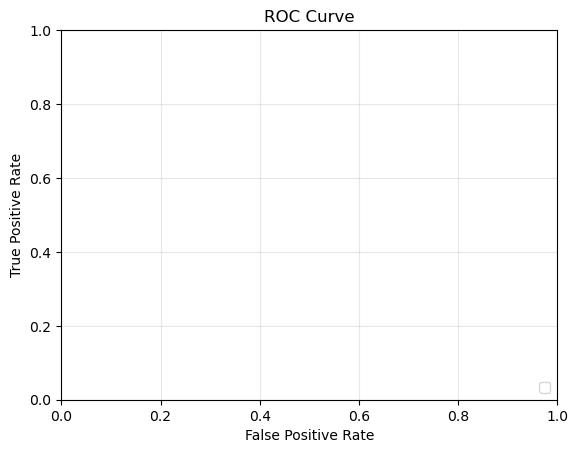

In [25]:
# Plots for ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [26]:
print("AUROC for each class:")
for i in range(y_binarized.shape[1]):
    print(f"Class {i}: {roc_auc[i]:.4f}")

AUROC for each class:
Class 0: 0.5424
Class 1: 0.6589
Class 2: 0.5812
